![spam](img/JB2.png)

In [18]:
%%HTML
<script src="require.js"></script>

##Datos grupo 1  > Modelo 0 >>. Current (Rafa)

## 1.   Importing libraries and loading data

In [19]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Normalization  libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Tensorflow with keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Easy graphs with plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'


# Matplotlib plots look like
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)
import pickle as pk

#import scipy
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [20]:
# Importing tensors
X_train = np.load('./outputs/split/X_train.npy')
X_val = np.load('./outputs/split/X_val.npy')
X_test = np.load('./outputs/split/X_test.npy')
y_train = np.load('./outputs/split/y_train.npy') #shape is 130513,24,1
y_val = np.load('./outputs/split/y_val.npy') #shape is 2665,24,1
y_test = np.load('./outputs/split/y_test.npy') #357,24,1

In [21]:
print(y_test.shape)

(238, 36, 1)


In [22]:
!mlflow


/bin/bash: mlflow: command not found


## 2.   Setting the model

<summary>
    <font size="4" color="orange"><b>1.1 Setting the parameters according to the tensors created in JNB1</b></font>
</summary>

In [23]:
n_pasado = (24 * 7)+12
n_futuro = 36 # cambio a 36 (original24)
n_salto = 0  # cambio a 0 (originala +12)

nom_attr = ['Energy_Demand', 
            
            'Month', 
            'Day', 
            'Hour',
            'PC1_Weather',
            'PC2_Weather',
            'Monday_Holiday',
            'Tuesday_Aft_Hol', 
            'Easter_week', 
            'May_1s', 
            'May_10t', 
            'Sept_16',
            'Nov_2nd', 
            'Before_Christmas_NY', 
            'Christmas_NY',
            'After_Christmas_NY' ]
n_attr = len(nom_attr)


<summary>
    <font size="4" color="orange"><b>1.2 Configuring the LSTM Encoder-Decoder model</b></font>
</summary>

LSTM UNIT

Such that:

* Forget Gate $F$: a NN with sigmoid 
* Candidate layer $C$: a NN with Tanh
* Input Gate $I$: a NN with sigmoid
* Output Gate $O$: a NN with sigmoid
* Hidden state $h$: a vector, in our case we set $h\in\mathbb{R}^{100}$
* Memory state $c$: a vector, in our case we set $c\in\mathbb{R}^{100}$


In [24]:
# Configuration of the encoder
encoder_inputs = layers.Input(shape=(n_pasado, n_attr))

encoder_l1 = layers.LSTM(25, return_state=True)# 100: dimension of hidden states
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

In [25]:
# Configuration of the encoder
decoder_rvec = layers.RepeatVector(n_futuro) # repeat vector 24 times
decoder_inputs = decoder_rvec(encoder_outputs1[0])

decoder_l1 = layers.LSTM(25, return_sequences=True)
decoder_l1_output = decoder_l1(decoder_inputs, initial_state=encoder_states1)

decoder_l2 = layers.TimeDistributed(layers.Dense(1)) # just one dense layer
decoder_outputs = decoder_l2(decoder_l1_output)

In [26]:
modelo = keras.models.Model(encoder_inputs, decoder_outputs)
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 16)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 25),         4200        ['input_2[0][0]']                
                                 (None, 25),                                                      
                                 (None, 25)]                                                      
                                                                                                  
 repeat_vector (RepeatVector)   (None, 36, 25)       0           ['lstm_1[0][0]']                 
                                                                                              

## 3.   Training the model

Let $F_\theta: {\rm Mat}_{180\times 18}(\mathbb{R})\rightarrow \mathbb{R}^{24}$ be the nonlinear mapping given by the LSTM model where $\theta \in\mathbb{R}^{128,101}$ is the vector of parameters to fit

The *training*, *validation* and *test* sets are codificated by the tensors $X_{180\times 18\times m}$ and $Y_{24\times 1\times m}$ for $m = m_{\rm train}, m_{\rm val}, m_{\rm test}$, as above. This tensors are, in each case,  just $m$ samples of the ordered pairs in ${\rm Mat}_{180\times 18}(\mathbb{R})\times \mathbb{R}^{24}$: $$\{(X^1,Y^1),(X^2,Y^2)
\dots(X^m,Y^m)\}.$$



<summary>
    <font size="3" color="palevioletred"><b>Loss function</b></font>
</summary>

For fixed $\theta$ and tensor pair $X$ and $Y$, we set the **loss function** in terms of the MAE metric with the $\ell_1$ norm: 

$${\rm Loss}(X) = \frac{1}{m}\sum_{k=1}^m{\|F_\theta(X^k)-Y^k\|_1}$$



<summary>
    <font size="3" color="palevioletred"><b>Hyperparameters</b></font>
</summary>

* **epochs** (upper bound) = 25: An epoch is when an entire training set is passed  through the NN only once.

* **batch size** = 32: Total number of training examples present in a single batch.

* **patience** = 5:  Number of epochs with no improvement after which training will be stopped, in our case with respect to ${\rm Loss}(X_{\rm val})$.

* **learning rate** $\alpha_{\rm epoch} = 1\times 10^{-3} \times 0.9 ^{\rm epoch}$

<summary>
    <font size="3" color="palevioletred"><b>Training process</b></font>
</summary>

In [27]:
## Sets the function for the rate learning in such a way that earning rate is smaller en each epoch
reduce_lr = keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x) 

## During the run, the models of "best" result are stored according to "val_loss"

path_checkpoint = "./outputs/h5/model_checkpoint.h5"
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

## Setting the number of epochs with no improvement after which training will be stopped, 
## with respect to "val_loss". This is to avoid overfitting.
es_callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0, 
    patience=5 ### probar con menos
    
)

modelo.compile(
    optimizer=keras.optimizers.Adam(),  ### un tipo de descenso de gradiente más eficiente 'momento-inercia'
    loss="mae", ### determinación de la función de costo
    metrics=['accuracy']
)

history = modelo.fit(
    X_train,
    y_train,
    epochs=25,
    validation_data=(X_val,y_val),
    batch_size=32,
    callbacks=[reduce_lr, es_callback]
) ### guardar este history para graficar

Epoch 1/25
4079/4079 [==============================] - 347s 83ms/step - loss: 0.0478 - accuracy: 1.4473e-04 - val_loss: 0.0281 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/25
4079/4079 [==============================] - 343s 84ms/step - loss: 0.0320 - accuracy: 1.4558e-04 - val_loss: 0.0239 - val_accuracy: 0.0000e+00 - lr: 9.0000e-04
Epoch 3/25
4079/4079 [==============================] - 346s 85ms/step - loss: 0.0291 - accuracy: 1.4558e-04 - val_loss: 0.0213 - val_accuracy: 0.0000e+00 - lr: 8.1000e-04
Epoch 4/25
4079/4079 [==============================] - 351s 86ms/step - loss: 0.0274 - accuracy: 1.4558e-04 - val_loss: 0.0206 - val_accuracy: 0.0000e+00 - lr: 7.2900e-04
Epoch 5/25
4079/4079 [==============================] - 350s 86ms/step - loss: 0.0261 - accuracy: 1.4558e-04 - val_loss: 0.0202 - val_accuracy: 0.0000e+00 - lr: 6.5610e-04
Epoch 6/25
4079/4079 [==============================] - 348s 85ms/step - loss: 0.0252 - accuracy: 1.4558e-04 - val_loss: 0.0208 - val_accuracy: 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



4079/4079 [==============================] - 357s 87ms/step - loss: 0.0226 - accuracy: 1.4558e-04 - val_loss: 0.0196 - val_accuracy: 0.0000e+00 - lr: 2.8243e-04
Epoch 14/25
4079/4079 [==============================] - 358s 88ms/step - loss: 0.0224 - accuracy: 1.4558e-04 - val_loss: 0.0196 - val_accuracy: 0.0000e+00 - lr: 2.5419e-04
Epoch 15/25
4079/4079 [==============================] - 353s 87ms/step - loss: 0.0222 - accuracy: 1.4558e-04 - val_loss: 0.0195 - val_accuracy: 0.0000e+00 - lr: 2.2877e-04


## 4.   Model validation

In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


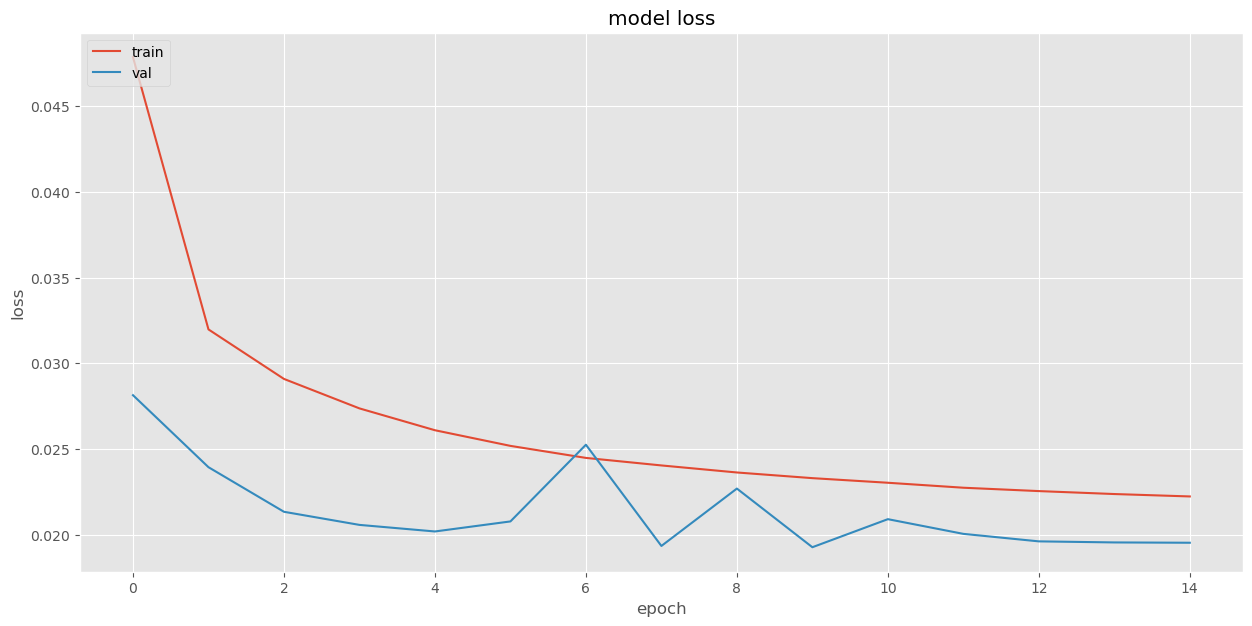

In [29]:
# Model Loss Chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
## 5.   Model test results

In [31]:
df_test = pd.read_csv('./outputs/PCA/pca_exogenas_test.csv')
del df_test["Unnamed: 0"]

In [32]:
y_est = modelo.predict(X_test)
y_test[:,:,0].ravel().shape, y_est[:,:,0].ravel().shape, df_test['Date_timed'][n_pasado + n_salto:].shape

8/8 [==============================] - 3s 19ms/step


((8568,), (8568,), (8580,))

In [33]:
df_test

,PC1_Weather,PC2_Weather,Date_timed,Energy_Demand,Day,Hour,Month,Tmax-Cab,Tmax-Hmo,Tmax-Obr,...,Monday_Holiday,Tuesday_Aft_Hol,Easter_week,May_1s,May_10t,Sept_16,Nov_2nd,Before_Christmas_NY,Christmas_NY,After_Christmas_NY
0,1.700324,-0.069763,2021-11-30 00:00:00,2491.00,1,0,11,29.5,31.5,29.0,...,0,0,0,0,0,0,0,0,0,0
1,1.700324,-0.069763,2021-11-30 01:00:00,2394.00,1,1,11,29.5,31.5,29.0,...,0,0,0,0,0,0,0,0,0,0
2,1.700324,-0.069763,2021-11-30 02:00:00,2313.00,1,2,11,29.5,31.5,29.0,...,0,0,0,0,0,0,0,0,0,0
3,1.700324,-0.069763,2021-11-30 03:00:00,2254.00,1,3,11,29.5,31.5,29.0,...,0,0,0,0,0,0,0,0,0,0
4,1.700324,-0.069763,2021-11-30 04:00:00,2203.00,1,4,11,29.5,31.5,29.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,3.416347,-0.228364,2022-11-29 19:00:00,2557.63,1,19,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0
8756,3.416347,-0.228364,2022-11-29 20:00:00,2520.09,1,20,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0
8757,3.416347,-0.228364,2022-11-29 21:00:00,2483.82,1,21,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0
8758,3.416347,-0.228364,2022-11-29 22:00:00,2393.89,1,22,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#create forlder/ verify if the folder exists
scalers = pk.load(open("./outputs/DataProcessing/scalers.pkl",'rb'))

In [35]:
scaler = scalers['Energy_Demand']
yr = scaler.inverse_transform(y_test[:,:,0].ravel().reshape(-1, 1))
yh = scaler.inverse_transform(y_est[:,:,0].ravel().reshape(-1, 1))

In [36]:
df_test.tail(3)

,PC1_Weather,PC2_Weather,Date_timed,Energy_Demand,Day,Hour,Month,Tmax-Cab,Tmax-Hmo,Tmax-Obr,...,Monday_Holiday,Tuesday_Aft_Hol,Easter_week,May_1s,May_10t,Sept_16,Nov_2nd,Before_Christmas_NY,Christmas_NY,After_Christmas_NY
8757,3.416347,-0.228364,2022-11-29 21:00:00,2483.82,1,21,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0
8758,3.416347,-0.228364,2022-11-29 22:00:00,2393.89,1,22,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0
8759,3.416347,-0.228364,2022-11-29 23:00:00,2291.08,1,23,11,24.0,26.5,28.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df_est = pd.DataFrame({
    "Actual": yr.ravel(),
    "Estimated": yh.ravel(),
    "Date_timed": df_test["Date_timed"][n_pasado + n_salto:]     
})

ValueError: array length 8568 does not match index length 8580

In [ ]:
df_est['Date_timed']= pd.to_datetime(df_est['Date_timed'])
df_est["Hour"] = df_est['Date_timed'].dt.hour

In [ ]:
real=[]
estimada =[]

df_est_result = pd.DataFrame(columns=['Date_timed',"MAPE"])

for i, row in df_est.iterrows():

    n = row['Hour']
    
    real.append(row['Actual'])
    estimada.append(row['Estimated'])
    
   
    if n == 23: #35 < de las sig, 36 hrs
        df_est_result = df_est_result.append(pd.DataFrame({"Date_timed": row['Date_timed'],
                                           "MAPE": (mean_absolute_percentage_error(real, estimada))*100, 
                                           "R2": stats.pearsonr(real, estimada)[0]}, 
                                            index=[0]), ignore_index=True)
        n=0
        
        real=[]
        estimada =[]
    n+=1


In [ ]:
df_est_result

In [ ]:
df_est_result.to_csv('./outputs/Training_comparativos/corrida_pcagral_25_5.csv')
df_est.to_csv('./outputs/Training_comparativos/tabla_original_pcagral_25_5.csv')

In [ ]:
df_est_result['Date'] = df_est_result['Date_timed'].astype(str)
df_est_result['Date'] = df_est_result['Date'].str[:10]
df_est_result['Date'] = pd.to_datetime(df_est_result['Date'])

### Seasons splits

In [ ]:
df_est_result_summer = df_est_result[(df_est_result['Date'] >= '2022-06-21') 
                   & (df_est_result['Date'] < '2022-09-23')]

df_est_result_autumn = df_est_result[(df_est_result['Date'] >= '2021-09-23') 
                   & (df_est_result['Date'] < '2022-12-21')]

df_est_result_winter = df_est_result[(df_est_result['Date'] >= '2021-12-21') 
                   & (df_est_result['Date'] < '2022-03-21')]

df_est_result_spring = df_est_result[(df_est_result['Date'] >= '2022-03-21') 
                   & (df_est_result['Date'] < '2022-06-21')]

In [ ]:
fig = go.Figure()

fig.add_trace(go.Violin(y=df_est_result_spring['MAPE'],
                        name='SPRING MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(158, 202, 57,0.5)", 
                        line=dict(color="#9eca39")))

fig.add_trace(go.Violin(y=df_est_result_summer['MAPE'],
                        name='SUMMER MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(249, 190, 4,0.5)", 
                        line=dict(color="#F9BE04")))

fig.add_trace(go.Violin(y=df_est_result_autumn['MAPE'],
                        name='AUTUMN MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(198, 111, 66,0.5)", 
                        line=dict(color="#C66F42")))

fig.add_trace(go.Violin(y=df_est_result_winter['MAPE'],
                        name='WINTER MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(112, 163, 187,0.5)", 
                        line=dict(color="#70A3BB")))



fig.update_layout(title_text="MAPE 4 Seasons", height=600) 
fig.show(renderer = "notebook")
#iplot(fig, image='svg', filename='violinplotmapelstmendoderdecoder', image_width=1280, image_height=640)

In [ ]:
#TEST CHART BY MONTH

fig = go.Figure()

fig.add_trace(go.Violin(y=df_est_result_january['MAPE'],
                        name='January MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(158, 202, 57,0.5)", 
                        line=dict(color="#9eca39")))

fig.add_trace(go.Violin(y=df_est_result_february['MAPE'],
                        name='February MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(249, 190, 4,0.5)", 
                        line=dict(color="#F9BE04")))

fig.add_trace(go.Violin(y=df_est_result_march['MAPE'],
                        name='March MAPE',
                        box_visible=True,
                        meanline_visible=True,
                        fillcolor="rgba(198, 111, 66,0.5)", 
                        line=dict(color="#C66F42")))

# Add more traces for the remaining months

fig.update_layout(title_text="MAPE by Month",
                   xaxis_title="Month",
                   yaxis_title="MAPE",
                   height=600)

# Update the x-axis labels to display the month names
fig.update_xaxes(type='category',
                 categoryorder='category ascending',
                 categoryarray=['January', 'February', 'March', ...])

fig.show(renderer = "notebook")


In [ ]:
#AGREGAR LS GRAFICAS POR DIA, MES Y HORA DEL DIA

## 6.   Model export

**H5** is a file format to store structured data, it's not a model by itself. Keras saves models in this format as it can easily store the weights and model configuration in a single file.

In [ ]:
modelo.save('./outputs/h5/modelo.h5')

In [ ]:
#from IPython import display
#display.Image("https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png", embed = True)

<summary>
    <font size="4" color="gray"> Maestría en Ciencia de Datos | Universidad de Sonora </font>
</summary>
<font size="1" color="gray"> Blvd. Luis Encinas y Rosales s/n Col. Centro. Edificio 3K1 planta baja C.P. 83000, Hermosillo, Sonora, México </font>
<font size="1" color="gray"> mcd@unison.mx </font>
<font size="1" color="gray"> Tel: +52 (662) 259 2155  </font>